In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.evolutionaryalgo import quadratic_loss_function
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import scipy

In [2]:
style.use('ggplot')

# Run distribution model

In [3]:
NRUNS = 1

In [4]:
params = {"fundamental_value": 166,
              "trader_sample_size": 10, "n_traders": 1000,
              "ticks": 2235, "std_fundamental": 0.0530163128919286,
              "std_noise": 0.10696588473846724, "w_random": 1.0,
              "w_fundamentalists": 10.0, "w_momentum": 15.0,
              "init_stocks": 50, "base_risk_aversion": 1.0,
               'spread_max': 0.004087, "horizon": 200}

In [5]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    traders.append(traders)
    obs.append(orderbook)

500


# Analyse dynamics

In [6]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

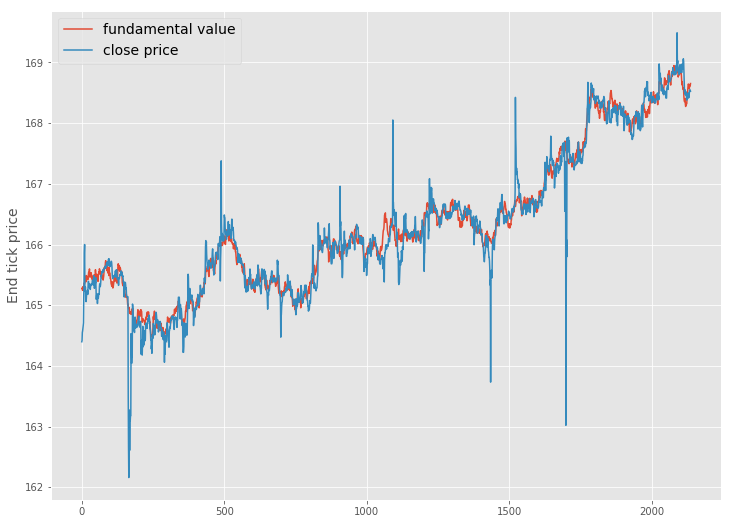

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals[0], label='fundamental value')
ax1.plot(mc_prices.index, mc_prices[0], label='close price')

ax1.set_ylabel('End tick price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

#fig.savefig('behavioural_hypothesis.png')

## Indirect Calibration
To calibrate the model parameters, I minimize the following quadtratic loss function: 

$J = J(m) = (m^{sim} - m^{emp})' W (m^{sim} - m^{emp}) $

The first term is the transpose of the difference between simulated and actual moments. The second term is the Idendity matrix. The third term is the difference between simulated and empirical moments. 

The next step is to determine the parameter bounds. Table 1 provides an overview.

| Parameter | Values (start, stop, step) |
| -------------| ------------|
| **trader_sample_size**      | 1, 30, 10      |
| **std_noise**       | 0.05, 0.30, 0.01      |
| **w_fundamentalists**       | 0.0, 100.0., 1.0      |
| **w_momentum**       | 0.0, 100.0, 1.0      |
| **horizon_max**       | 9, 30, 1      |
| **base_risk_aversion**       | 0.5, 10.0, 0.5       |
| **init_stocks**       | 10, 100, 10      |
*Table 1 Parameter bounds*

In [8]:
problem = {
  'num_vars': 7,
  'names': ['trader_sample_size', 'std_noise', 
            'w_fundamentalists', 'w_momentum',
            'init_stocks', 'base_risk_aversion',
           'horizon'],
  'bounds': [[1, 30], [0.05, 0.30], 
             [0.0, 100.0], [0.0, 100.0], 
             [1, 100], [0.1, 15.0],
             [9, 30]]
}

In [9]:
empirical_moments = np.array([ -9.56201354e-03,  -9.55051841e-02,  -5.52010512e-02,
         3.35217232e-01,   1.24673150e+01,   3.46352635e-01,
         2.72135459e-01,   1.88193342e-01,   1.75876698e-01]) # all moments from Schasfoort 2018 except for the cointegr moment

In [16]:
population_size = 1

In [17]:
latin_hyper_cube = latin.sample(problem=problem, N=population_size)
latin_hyper_cube = latin_hyper_cube.tolist()

Transform some parameters to integers:

In [18]:
for idx, parameters in enumerate(latin_hyper_cube):
    # ints: 0, 4, 6
    latin_hyper_cube[idx][0] = int(latin_hyper_cube[idx][0])
    latin_hyper_cube[idx][4] = int(latin_hyper_cube[idx][4])
    latin_hyper_cube[idx][6] = int(latin_hyper_cube[idx][6])

In [13]:
fixed_parameters = {"ticks": 2235, "fundamental_value": 166,
                    'n_traders': 1000, 'std_fundamental': 0.0530163128919286, 'spread_max': 0.004087, 
                    "w_random": 1.0}

In [14]:
import constrNMPy as cNM 

### What I need to optimize model

* init guess = latin hypercube sample 
* list of LB for all parameters
* list of HB for all parameters
* function which takes as input list of parameters and outputs its J-score

In [20]:
problem['names']

['trader_sample_size',
 'std_noise',
 'w_fundamentalists',
 'w_momentum',
 'init_stocks',
 'base_risk_aversion',
 'horizon']

In [19]:
latin_hyper_cube

[[22,
  0.23362219092236586,
  58.56886341766124,
  35.18232041845091,
  48,
  0.3066593229633973,
  10]]

In [21]:
dict(zip(problem['names'], latin_hyper_cube[0]))

{'trader_sample_size': 22,
 'std_noise': 0.23362219092236586,
 'w_fundamentalists': 58.56886341766124,
 'w_momentum': 35.18232041845091,
 'init_stocks': 48,
 'base_risk_aversion': 0.3066593229633973,
 'horizon': 10}

In [25]:
def distr_model_performance(input_parameters):
    """Simple function calibrate uncertain model parameters"""
    # update params 
    uncertain_parameters = dict(zip(problem['names'], input_parameters))
    params = {"ticks": 2235, "fundamental_value": 166, 'n_traders': 1000, 'std_fundamental': 0.0530163128919286, 
              'spread_max': 0.004087, "w_random": 1.0}
    params.update(uncertain_parameters)
    
    empirical_moments = np.array([ -9.56201354e-03,  -9.55051841e-02,  -5.52010512e-02,
         3.35217232e-01,   1.24673150e+01,   3.46352635e-01,
         2.72135459e-01,   1.88193342e-01,   1.75876698e-01])
    
    traders = []
    obs = []
    # run model with parameters
    for seed in range(2): #TODO update fixed runs?
        traders, orderbook = init_objects_distr(params, seed)
        traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
        traders.append(traders)
        obs.append(orderbook)
    
    # store simulated stylized facts
    mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

    first_order_autocors = []
    autocors1 = []
    autocors5 = []
    mean_abs_autocor = []
    kurtoses = []
    spy_abs_auto10 = []
    spy_abs_auto25 = []
    spy_abs_auto50 = []
    spy_abs_auto100 = []
    for col in mc_returns:
        first_order_autocors.append(autocorrelation_returns(mc_returns[col][1:], 25))
        autocors1.append(mc_returns[col][1:].autocorr(lag=1))
        autocors5.append(mc_returns[col][1:].autocorr(lag=5))
        mean_abs_autocor.append(autocorrelation_abs_returns(mc_returns[col][1:], 25))
        kurtoses.append(mc_returns[col][2:].kurtosis())
        spy_abs_auto10.append(mc_returns[col][1:].abs().autocorr(lag=10))
        spy_abs_auto25.append(mc_returns[col][1:].abs().autocorr(lag=25))
        spy_abs_auto50.append(mc_returns[col][1:].abs().autocorr(lag=50))
        spy_abs_auto100.append(mc_returns[col][1:].abs().autocorr(lag=100))

    stylized_facts_sim = np.array([
        np.mean(first_order_autocors),
        np.mean(autocors1),
        np.mean(autocors5),
        np.mean(mean_abs_autocor),
        np.mean(kurtoses),
        np.mean(spy_abs_auto10),
        np.mean(spy_abs_auto25),
        np.mean(spy_abs_auto50),
        np.mean(spy_abs_auto100)
        ])

    # calculate the cost
    cost = quadratic_loss_function(stylized_facts_sim, empirical_moments, np.identity(len(stylized_facts_sim)))   
    return cost

In [31]:
latin_hyper_cube[0]

[22,
 0.23362219092236586,
 58.56886341766124,
 35.18232041845091,
 48,
 0.3066593229633973,
 10]

In [29]:
distr_model_performance(latin_hyper_cube[0])

500
500


219944.80963769858

In [15]:
x0=[2.5,2.5]

# Define lower and upper bounds (None indicates no bound)
LB=[2,2]
UB=[None,3]

# Call optimizer
res=cNM.constrNM(cNM.test_funcs.rosenbrock,x0,LB,UB,full_output=True)

# Print results
cNM.printDict(res)

fopt  =  101.00000005355369
iter  =  40
funcalls  =  78
warnflag  =  0
xopt  =  [2. 3.]
allvecs  =  None


True